In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard
import os
import shutil
import time
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from keras.models import Model
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.colors as colors

In [ ]:
#install latex
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
!apt install cm-super

In [ ]:
#To import data set manually
from google.colab import files
uploaded=files.upload()

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/openfoamDATA/all_data_sonic.hdf5' all_data.hdf5

In [ ]:
!cp '/content/drive/MyDrive/test_data.hdf5' all_data.hdf5

In [ ]:
!cp '/content/drive/MyDrive/my_model.h5' my_model.h5

In [ ]:
!cp '/content/drive/MyDrive/openfoamDATA/all_data_backward.hdf' test_data_backward.hdf5

# **Start**




# keras_model

In [ ]:
from keras.models import Model
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.utils.vis_utils import plot_model


def inception_module(filters=None, inputs=None):
    tower_0 = Conv2D(int(filters / 4), (1, 1), padding='same', activation='linear')(inputs)

    tower_1 = Conv2D(int(filters / 4), (1, 1), padding='same', activation='linear')(inputs)
    tower_1 = Conv2D(int((filters * 3) / 8), (3, 3), padding='same', activation='linear')(tower_1)

    tower_2 = Conv2D(int(filters / 8), (1, 1), padding='same', activation='linear')(inputs)
    tower_2 = Conv2D(int(filters / 8), (5, 5), padding='same', activation='linear')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    tower_3 = Conv2D(int(filters / 4), (1, 1), padding='same', activation='linear')(tower_3)

    concat = concatenate([tower_0, tower_1, tower_2, tower_3], axis=3)

    return concat


def keras_model(x_train, save_model=True):
    inputs = Input(x_train.shape[1:])  # Input(shape), return a tensor
    # Initial shape: (None, 50, 150, 1). Here, the channel number / depth might get changed, but don't worry!

    # 2 Conv. layer
    conv1 = Conv2D(16, (3, 3), padding='same', activation='linear')(inputs)  # (None, 50, 150, 16)
    conv2 = Conv2D(16, (5, 5), padding='same', activation='linear')(conv1)  # (None, 50, 150, 16)

    # 4 inception_module module followed by a max pooling
    inception1 = inception_module(filters=32, inputs=conv2)  # (None, 50, 150, 32)
    # inception1 = inception_module(filters=32, inputs=inception1)
    inception1 = inception_module(filters=32, inputs=inception1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(inception1)  # (None, 25, 75, 32)

    inception2 = inception_module(filters=64, inputs=pool1)  # (None, 25, 75, 64)
    # inception2 = inception_module(filters=64, inputs=inception2)
    inception2 = inception_module(filters=64, inputs=inception2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(inception2)  # (None, 12, 37, 64)

    inception3 = inception_module(filters=128, inputs=pool2)  # (None, 12, 37, 128)
    inception3 = inception_module(filters=128, inputs=inception3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(inception3)  # (None, 6, 18, 128)

    inception4 = inception_module(filters=256, inputs=pool3)  # (None, 6, 18, 256)
    # inception4 = inception_module(filters=256, inputs=inception4)
    inception4 = inception_module(filters=256, inputs=inception4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(inception4)  # (None, 3, 9, 256)

    # 2 inception_module module
    inception5 = inception_module(filters=512, inputs=pool4)  # (None, 3, 9, 512)
    inception6 = inception_module(filters=512, inputs=inception5)  # (None, 3, 9, 512)
    #inception6 = inception_module(filters=512, inputs=inception6)

    # 4 Residual connection
    add1 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(inception6),
                        inception4], axis=3)  # (None, 3, 9, 512) -> (None, 6, 18, 256)
    inception7 = inception_module(filters=256, inputs=add1)
    inception7 = inception_module(filters=256, inputs=inception7)
    # inception7 = inception_module(filters=256, inputs=inception7)
    add2 = concatenate(
        [ZeroPadding2D(((0, 0), (1, 0)))(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(inception7)),
         inception3], axis=3)  # (None, 6, 18, 256) -> (None, 12, 36, 128) -> (None, 12, 37, 128)
    inception8 = inception_module(filters=128, inputs=add2)
    inception8 = inception_module(filters=128, inputs=inception8)
    # inception8 = inception_module(filters=128, inputs=inception8)
    add3 = concatenate(
        [ZeroPadding2D(((1, 0), (1, 0)))(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(inception8)),
         inception2], axis=3)  # (None, 12, 37, 128) -> (None, 24, 74, 64) -> (None, 25, 75, 64)
    inception9 = inception_module(filters=64, inputs=add3)
    inception9 = inception_module(filters=64, inputs=inception9)
    # inception9 = inception_module(filters=64, inputs=inception9)

    add4 = concatenate(
        [Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(inception9),
         inception1], axis=3)  # (None, 25, 75, 64) -> (None, 50, 150, 32)

    # 1 Conv. for output with linear activation
    outputs = Conv2D(1, (1, 1), activation='linear')(add4)

    model = Model(inputs=[inputs], outputs=[outputs])

    if save_model:
        plot_model(model, to_file='model_architecture_with_inception.png', show_shapes=True, show_layer_names=True)

    return model

# lstm_1

In [ ]:

def lstm_model_1():
    inputs = tf.keras.Input(shape=(20, 50, 150, 4))

    c1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'))(inputs)  # (None, 50, 150, 32)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c1)  # (None, 25, 75, 32)

    c2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same'))(x)  # (None, 25, 75, 64)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c2)  # (None, 13, 38, 64)

    c3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))(x)  # (None, 13, 38, 128)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c3)  # (None, 7, 19, 128)

    x = tf.keras.layers.ConvLSTM2D(filters=256, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0))))(x)
    x = tf.keras.layers.Add()([x, c3])

    x = tf.keras.layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0))))(x)
    x = tf.keras.layers.Add()([x, c2])

    x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.Add()([x, c1])

    x = tf.keras.layers.Conv3D(filters=4, kernel_size=(3, 3, 3), activation='linear', padding='same', data_format='channels_last')(x)

    model = Model(inputs=inputs, outputs=x)
    plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=False)
    print(model.summary())
    return model


# keras_model

In [ ]:
def keras_model(layers=3, filters=32, kernel_size=(3, 3), activation='relu', recurrent_activation='tanh', dropout=0.0,
                recurrent_dropout=0.0):
    input_shape = (None, 50, 150, 4)

    seq = Sequential()
    if layers >= 1:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 2:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 3:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 4:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 5:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 6:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 7:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 8:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))
    if layers >= 9:
        seq.add(ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation=activation,
                           recurrent_activation=recurrent_activation, padding='same', dropout=dropout,
                           recurrent_dropout=recurrent_dropout, return_sequences=True))

    seq.add(Conv3D(filters=4, kernel_size=(3, 3, 3), activation='linear', padding='same', data_format='channels_last'))
    #plot_model(model, to_file='convlstm2d_with_resnet.png', show_shapes=True, show_layer_names=False)
    print(seq.summary())
    return seq

# Read data

In [ ]:
def read_dataset(path=None, split=0.8, print_shape=False):
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:, 0:20, ...]
    y = hdf5_file["sim_data"][:, 1:21, ...]
    sim_no = hdf5_file["sim_no"][:, 0]
    hdf5_file.close()

    total_sim = x.shape[0]
    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, sim_no_train, sim_no_test

#train

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, ZeroPadding2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import h5py
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.callbacks import EarlyStopping

lr=5e-4
batch_size=1
epochs=10
hdf5_path = '/content/all_data.hdf5'

x_train, y_train, x_test, y_test, _, _ = read_dataset(path=hdf5_path, split=0.9, print_shape=False)

optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model = keras_model(layers=3, filters=32, kernel_size=(3, 3), activation='relu', recurrent_activation='tanh', dropout=0.0, recurrent_dropout=0.0)

model.compile(loss='MSE', optimizer=optimizer, metrics=['MSE'])

callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0, patience=10)]

model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks)

model.save('my_model1.h5')

In [ ]:
#to search for the best lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model= lstm_model_1()

model.compile(loss='MSE', optimizer=optimizer, metrics=['MSE'])

hdf5_path = '/content/all_data.hdf5'

x_train, y_train, x_test, y_test, _, _ = read_dataset(path=hdf5_path, split=0.9, print_shape=False)

history = model.fit(x=x_train, y=y_train, epochs=100, callbacks=[lr_schedule], verbose=1)
                    
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 8])

In [ ]:
#callback to plot on the fly

import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

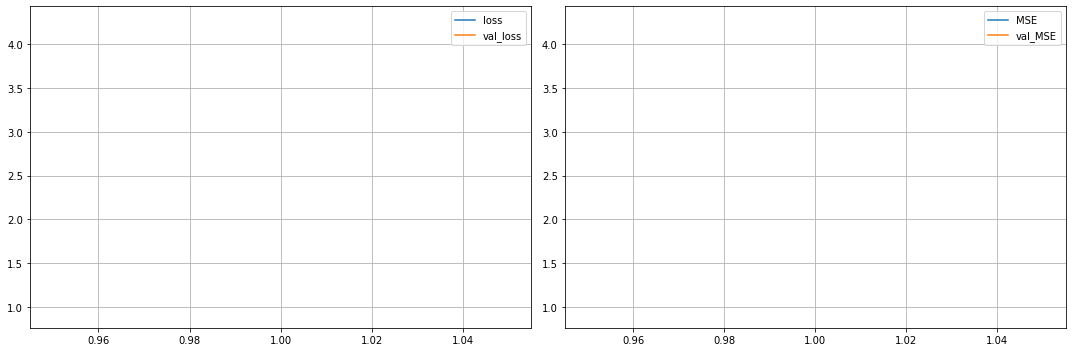

Epoch 2/50
12/28 [===========>..................] - ETA: 37s - loss: 0.6641 - MSE: 0.6641

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, ZeroPadding2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import h5py
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


hdf5_path = '/content/all_data.hdf5'
lr=5e-4
batch_size=32
epochs=50
x_train, y_train, x_test, y_test, _, _ = read_dataset(path=hdf5_path, split=0.9, print_shape=False)

optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model = lstm_model_1()
model.compile(loss='MSE', optimizer=optimizer, metrics=['MSE'])

callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0, patience=10), TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True), PlotLearning()]

model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks)

score = model.evaluate(x=x_test, y=y_test, verbose=0)

print('Average Mean Squared Error:', score[0])

model.save('my_model3.h5')



In [ ]:
for i in range(2):
  print(i)

0
1


In [ ]:
#costum training to use graph mode?

@tf.function
def train(model, dataset, optimizer):
  for x, y in dataset:
    with tf.GradientTape() as tape:
      # training=True is only needed if there are layers with different
      # behavior during training versus inference (e.g. Dropout).
      prediction = model(x, training=True)
      loss = loss_fn(prediction, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Test model

(20, 31, 50, 250, 3)
x_test.shape: (1, 20, 50, 250, 3)
y_test.shape: (1, 20, 50, 250, 3)



IndexError: ignored

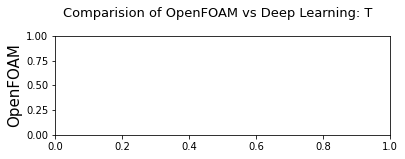

In [ ]:
import os
import shutil
from keras.models import load_model
model = load_model('my_model1.h5')

path='/content/plots/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)

    
def read_dataset(print_shape=True):
    x = []
    y = []
    hdf5_file = h5py.File('/content/all_data.hdf5', "r")
    data = hdf5_file["sim_data"][:, ...]
    hdf5_file.close()
    print(data.shape)
    for i in [0]:
        for j in range(20):
            x.append(data[i, j, ...])
            y.append(data[i, j + 1, ...])

    x = np.array(x)
    y = np.array(y)

    x_test = x[None,:]
    y_test = y[None,:]

    if print_shape:
        print("x_test.shape: {}\ny_test.shape: {}\n".format(
            x_test.shape,
            y_test.shape))

    return x_test, y_test


x_test, y_test = read_dataset()

predicted_flow = model.predict(x_test, batch_size=5)

predicted_flow = predicted_flow.reshape(predicted_flow.shape[1:5])
y_test = y_test.reshape(y_test.shape[1:5])
for i in range(20):
    extent = 0, 3, 0, 1
    plt.suptitle('Comparision of OpenFOAM vs Deep Learning: p', fontsize=13)

    plt.subplot(211)
    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[i,:,:,2])
    maxp= np.max(y_test[i,:,:,2]);
    plt.clim(-1, maxp);
    plt.colorbar();

    plt.subplot(212)
    plt.ylabel('Deep Learning', fontsize=15)
    plt.imshow(predicted_flow[i,:,:,2],)
    plt.clim(-1, maxp);
    plt.colorbar();

    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
    plt.savefig('/content/plots/' + str(i) + 'p.png')
    plt.close()

    plt.suptitle('Comparision of OpenFOAM vs Deep Learning: T', fontsize=13)

    plt.subplot(211)
    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[i,:,:,3])
    maxt= np.max(y_test[i,:,:,3]);
    plt.clim(-1, maxt);
    plt.colorbar();

    plt.subplot(212)
    plt.ylabel('Deep Learning', fontsize=15)
    plt.imshow(predicted_flow[i,:,:,3],)
    plt.clim(-1, maxt);
    plt.colorbar();

    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
    plt.savefig('/content/plots/' + str(i) + 'T.png')
    plt.close()

    plt.suptitle('Comparision of OpenFOAM vs Deep Learning: Ux', fontsize=13)

    plt.subplot(211)
    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[i,:,:,0])
    plt.clim(-1, 3);
    plt.colorbar(); 

    plt.subplot(212)
    plt.ylabel('Deep Learning', fontsize=15)
    plt.imshow(predicted_flow[i,:,:,0],)
    plt.clim(-1, 3);
    plt.colorbar();

    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
    plt.savefig('/content/plots/' + str(i) + 'Ux.png')
    plt.close()

    plt.suptitle('Comparision of OpenFOAM vs Deep Learning: Uy', fontsize=13)

    plt.subplot(211)
    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[i,:,:,1])
    plt.clim(-1, 3);
    plt.colorbar(); 

    plt.subplot(212)
    plt.ylabel('Deep Learning', fontsize=15)
    plt.imshow(predicted_flow[i,:,:,1],)
    plt.clim(-1, 3);
    plt.colorbar();

    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
    plt.savefig('/content/plots/' + str(i) + 'Uy.png')
    plt.close()

# test data set

In [ ]:
#To import data set manually
from google.colab import files
uploaded=files.upload()

Saving all_data.hdf5 to all_data.hdf5


In [ ]:
import os
import shutil

path='/content/plots/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)

    
def read_dataset(print_shape=True):
    x = []
    y = []
    hdf5_file = h5py.File('/content/all_data.hdf5', "r")
    data = hdf5_file["sim_data"][:, ...]
    hdf5_file.close()
    print(data.shape)
    for i in [0]:
        for j in range(5):
            x.append(data[i, j, ...])
            y.append(data[i, j + 1, ...])

    x = np.array(x)
    y = np.array(y)

    x_test = x[None,:]
    y_test = y[None,:]

    if print_shape:
        print("x_test.shape: {}\ny_test.shape: {}\n".format(
            x_test.shape,
            y_test.shape))

    return x_test, y_test


x_test, y_test = read_dataset()

y_test = y_test.reshape(y_test.shape[1:5])

for i in range(5):

    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[i,:,:,2])


    plt.savefig('/content/plots/' + str(i) + 'p.png')
    plt.close()


    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[i,:,:,0])
    print(len(y_test[i,:,:,0]))


    plt.savefig('/content/plots/' + str(i) + 'Ux.png')
    plt.close()

    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[i,:,:,1])


    plt.savefig('/content/plots/' + str(i) + 'Uy.png')
    plt.close()


(971, 21, 50, 150, 4)
x_test.shape: (1, 5, 50, 150, 4)
y_test.shape: (1, 5, 50, 150, 4)

50


Exception ignored in: <function CapturableResource.__del__ at 0x7f5d1cc4cd40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 264, in __del__
    def __del__(self):
KeyboardInterrupt


50
50
50
50


# other test

In [ ]:
from keras.models import load_model
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def read_dataset(path=None, split=0.8, print_shape=False):
    hdf5_file = h5py.File(path, "r")
    x = hdf5_file["sim_data"][:10, 0:20, ...]
    y = hdf5_file["sim_data"][:10, 1:21, ...]
    sim_no = hdf5_file["sim_no"][:, 0]
    hdf5_file.close()

    total_sim = x.shape[0]
    x_train = x[:int(total_sim * split), ...]
    y_train = y[:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    sim_no_train = sim_no[:int(total_sim * split), ...]
    sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, sim_no_train, sim_no_test


hdf5_path = 'test_data.hdf5'
x_train, y_train, x_test, y_test, _, _ = read_dataset(path=hdf5_path, split=0.9, print_shape=True)
model = load_model('my_model3.h5')


which = 0
track = x_test[which, ...]

for j in range(20):
    new_pos = model.predict(track[np.newaxis, 0:20, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)



class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# And then compare the predictions
# to the ground truth
track2 = x_test[which][::, ::, ::, ::]
for i in range(20):
    fig = plt.figure(figsize=(15, 7.5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 3]

    plt.imshow(toplot, cmap='jet', alpha=.9, interpolation='bilinear', norm=MidpointNormalize(midpoint=0.), extent=extent)
    plt.colorbar();
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 3]
    if i >= 2:
        toplot = y_test[which][i - 1, ::, ::, 3]

    extent = 0, 3, 0, 1
    im = plt.imshow(toplot, cmap='jet', alpha=.9, interpolation='bilinear', norm=MidpointNormalize(midpoint=0.), extent=extent)
    plt.colorbar();
    plt.savefig('%i_animate.png' % (i + 1))

In [ ]:
import numpy as np
X = [2, 2, 1, 1, 1]
Y = [2, 2, 2, 2, 2]
XY = [4, 4, 2, 2, 2]

array =  np.arange(14).reshape((14,1))
print(array )
print('\n')
print(np.flip(array[(XY[0] + XY[1] + XY[2]):(XY[0] + XY[1] + XY[2] + XY[3])].reshape(Y[3], X[3]), 0))

np.flip(array[0:XY[0]].reshape(Y[0],X[0]),0)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]]


[[11]
 [10]]


array([[2, 3],
       [0, 1]])

# outro modelo


In [ ]:
def lstm_model_1():
    inputs = Input(shape=(50, 150, 4))

    c1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'))(inputs)  # (None, 50, 150, 32)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c1)  # (None, 25, 75, 32)

    c2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same'))(x)  # (None, 25, 75, 64)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c2)  # (None, 13, 38, 64)

    c3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))(x)  # (None, 13, 38, 128)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))(c3)  # (None, 7, 19, 128)

    x = tf.keras.layers.ConvLSTM2D(filters=256, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0))))(x)
    x = tf.keras.layers.Add()([x, c3])

    x = tf.keras.layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0))))(x)
    x = tf.keras.layers.Add()([x, c2])

    x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu',
                   recurrent_activation='hard_sigmoid', padding='same', return_sequences=True)(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same'))(x)
    x = tf.keras.layers.Add()([x, c1])

    x = tf.keras.layers.Conv3D(filters=4, kernel_size=(3, 3, 3), activation='linear', padding='same', data_format='channels_last')(x)

    model = Model(inputs=inputs, outputs=x)
    plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=False)
    print(model.summary())
    return model

In [ ]:
def inception_module(filters=None, inputs=None):
    tower_0 = Conv2D(int(filters / 4), (1, 1), padding='same', activation='relu')(inputs)

    tower_1 = Conv2D(int(filters / 4), (1, 1), padding='same', activation='relu')(inputs)
    tower_1 = Conv2D(int((filters * 3) / 8), (3, 3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(int(filters / 8), (1, 1), padding='same', activation='relu')(inputs)
    tower_2 = Conv2D(int(filters / 8), (5, 5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    tower_3 = Conv2D(int(filters / 4), (1, 1), padding='same', activation='relu')(tower_3)

    concat = concatenate([tower_0, tower_1, tower_2, tower_3], axis=3)

    return concat


def keras_model1(save_model=True):
    inputs = Input((50, 150, 4))  # Input(shape), return a tensor
    # Initial shape: (None, 50, 150, 4)

    x = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)  # (None, 50, 150, 16)
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)  # (None, 50, 150, 16)

    c1 = inception_module(filters=32, inputs=x)  # (None, 50, 150, 32)
    x = inception_module(filters=32, inputs=c1)
    x = inception_module(filters=32, inputs=x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # (None, 25, 75, 32)

    c2 = inception_module(filters=64, inputs=x)  # (None, 25, 75, 64)
    x = inception_module(filters=64, inputs=c2)
    x = inception_module(filters=64, inputs=x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # (None, 12, 37, 64)

    c3 = inception_module(filters=128, inputs=x)  # (None, 12, 37, 128)
    x = inception_module(filters=128, inputs=c3)
    x = inception_module(filters=128, inputs=x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # (None, 6, 18, 128)

    c4 = inception_module(filters=256, inputs=x)  # (None, 6, 18, 256)
    x = inception_module(filters=256, inputs=c4)
    x = inception_module(filters=256, inputs=x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # (None, 3, 9, 256)

    x = inception_module(filters=512, inputs=x)  # (None, 3, 9, 512)
    x = inception_module(filters=512, inputs=x)
    x = inception_module(filters=512, inputs=x)  # (None, 3, 9, 512)

    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, c4], axis=3)  # (None, 3, 9, 512) -> (None, 6, 18, 256)
    x = inception_module(filters=256, inputs=x)
    x = inception_module(filters=256, inputs=x)
    x = inception_module(filters=256, inputs=x)

    x = concatenate(
        [ZeroPadding2D(((0, 0), (1, 0)))(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)),
         c3], axis=3)  # (None, 6, 18, 256) -> (None, 12, 36, 128) -> (None, 12, 37, 128)
    x = inception_module(filters=128, inputs=x)
    x = inception_module(filters=128, inputs=x)
    x = inception_module(filters=128, inputs=x)

    x = concatenate(
        [ZeroPadding2D(((1, 0), (1, 0)))(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)),
         c2], axis=3)  # (None, 12, 37, 128) -> (None, 24, 74, 64) -> (None, 25, 75, 64)
    x = inception_module(filters=64, inputs=x)
    x = inception_module(filters=64, inputs=x)
    x = inception_module(filters=64, inputs=x)

    x = concatenate(
        [Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x),
         c1], axis=3)  # (None, 25, 75, 64) -> (None, 50, 150, 32)

    x = inception_module(filters=32, inputs=x)
    x = inception_module(filters=32, inputs=x)
    x = inception_module(filters=32, inputs=x)

    outputs = Conv2D(4, (1, 1), activation='linear')(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    print(model.summary())


    plot_model(model, to_file='model_architecture_with_inception2.png', show_shapes=True, show_layer_names=False)

    return model

In [ ]:
def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    data = hdf5_file["sim_data"][:, ...]
    hdf5_file.close()

    for j in range(data.shape[0]):
      for i in range(data.shape[1]-1):
        x.append(data[j, i, ...]) 
        y.append(data[j, i+1, ...])
    x = np.array(x)
    y = np.array(y)
    #x = x.reshape(x.shape + (1,))
    #y = y.reshape(y.shape + (1,))
    total_sim = (x.shape[0])/20  #divide this way to make testing easier - x_test[0] will be the first time step of one sim

    x_train = x[:(int(total_sim * split)*20), ...]
    y_train = y[:(int(total_sim * split)*20), ...]
    x_test = x[(int(total_sim * split)*20):int(total_sim)*20, ...]
    y_test = y[(int(total_sim * split)*20):int(total_sim)*20, ...]
    #sim_no_train = sim_no[:int(total_sim * split), ...]
    #sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test#, sim_no_train, sim_no_test

In [ ]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test= read_dataset(hdf5_path, split=0.9, print_shape=False)

x_train.shape


(40, 50, 150, 4)

In [ ]:
lr = 5e-04
model = keras_model1(x_train)
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['MSE'])
callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0.001, patience=5)]
train_info = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks)
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])
model.save('my_model.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 150, 4)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 150, 16)  592         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 150, 16)  2320        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 50, 150, 8)   136         conv2d_1[0][0]                   
______________________________________________________________________________________________

AssertionError: ignored

In [ ]:
!cp '/content/my_model.h5' '/content/drive/' my_model.h5

cp: target 'my_model.h5' is not a directory


In [ ]:
x_test[0,:].shape


(50, 150, 4)

In [ ]:
import os
import shutil
from keras.models import load_model
model = load_model('my_model.h5')

path='/content/plots/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)

#x_test, y_test = read_dataset()

predicted_flow =x_test[20*1,:]
predicted_flow = predicted_flow.reshape(1,50,150,4)

#predicted_flow = predicted_flow.reshape(predicted_flow.shape[1:5])
#y_test = y_test.reshape(y_test.shape[1:5])

for i in range(20):
    extent = 0, 3, 0, 1
    plt.suptitle('Comparision of OpenFOAM vs Deep Learning: p', fontsize=13)

    plt.subplot(311)
    plt.ylabel('OpenFOAM', fontsize=15)
    plt.imshow(y_test[20+i,:,:,2])
    maxp= np.max(y_test[20+i,:,:,2]);
    plt.colorbar();

    predicted_flow = model.predict(predicted_flow)

    plt.subplot(312)
    plt.ylabel('Deep Learning', fontsize=15)
    plt.imshow(predicted_flow[0,:,:,2],)
    plt.colorbar();

    plt.subplot(313)
    plt.ylabel('ERRO Relativo', fontsize=15)
    plt.imshow((y_test[20+i,:,:,2] - predicted_flow[0,:,:,2])/y_test[20+i,:,:,2])
    plt.colorbar();


    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
    plt.savefig('/content/plots/' + str(i) + 'p.png')
    plt.close()

 

In [ ]:
def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    data = hdf5_file["sim_data"][:, ...]
    hdf5_file.close()

    for j in range(data.shape[0]):
      for i in range(data.shape[1]-1):
        x.append(data[j, i, ...]) 
        y.append(data[j, i+1, ...])
    x = np.array(x)
    y = np.array(y)
    x = x.reshape((1,) + x.shape)
    y = y.reshape((1,) + y.shape)
    #y = y.reshape( y.shape +(1,) )
    total_sim = x.shape[1]

    x_train = x[:,:int(total_sim * split), ...]
    y_train = y[:,:int(total_sim * split), ...]
    x_test = x[int(total_sim * split):total_sim, ...]
    y_test = y[int(total_sim * split):total_sim, ...]
    #sim_no_train = sim_no[:int(total_sim * split), ...]
    #sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test#, sim_no_train, sim_no_test



In [ ]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test= read_dataset(hdf5_path, split=0.8, print_shape=False)

x_train.shape

(48, 1, 50, 150, 4)

In [ ]:
lr=1e-4
batch_size=1
epochs=50

optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model = lstm_model_1()
model.compile(loss='MSE', optimizer=optimizer, metrics=['MSE'])

callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0, patience=10), TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]#, PlotLearning()]

model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks)

score = model.evaluate(x=x_test, y=y_test, verbose=0)

print('Average Mean Squared Error:', score[0])

model.save('my_model3.h5')

The following Variables were used a Lambda layer's call (tf.nn.convolution_16), but
are not present in its tracked objects:
  <tf.Variable 'time_distributed_170/kernel:0' shape=(2, 2, 4, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_28), but
are not present in its tracked objects:
  <tf.Variable 'time_distributed_170/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


ValueError: ignored